In [1]:
import os

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import spatial

from operator import itemgetter

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [2]:
print("Available devices: %s" % tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset

In [3]:
os.listdir('datasets')

X_train = np.load('datasets/k49-train-imgs.npz')['arr_0']
Y_train = np.load('datasets/k49-train-labels.npz')['arr_0']

X_test = np.load('datasets/k49-test-imgs.npz')['arr_0']
Y_test = np.load('datasets/k49-test-labels.npz')['arr_0']

label_map = pd.read_csv('datasets/k49_classmap.csv')

###############################
# !!! Balance the dataset !!! #
###############################

In [4]:
print(Y_test[:10])
print(label_map)

[19 23 10 31 26 12 24  9 24  8]
    index codepoint char
0       0    U+3042    あ
1       1    U+3044    い
2       2    U+3046    う
3       3    U+3048    え
4       4    U+304A    お
5       5    U+304B    か
6       6    U+304D    き
7       7    U+304F    く
8       8    U+3051    け
9       9    U+3053    こ
10     10    U+3055    さ
11     11    U+3057    し
12     12    U+3059    す
13     13    U+305B    せ
14     14    U+305D    そ
15     15    U+305F    た
16     16    U+3061    ち
17     17    U+3064    つ
18     18    U+3066    て
19     19    U+3068    と
20     20    U+306A    な
21     21    U+306B    に
22     22    U+306C    ぬ
23     23    U+306D    ね
24     24    U+306E    の
25     25    U+306F    は
26     26    U+3072    ひ
27     27    U+3075    ふ
28     28    U+3078    へ
29     29    U+307B    ほ
30     30    U+307E    ま
31     31    U+307F    み
32     32    U+3080    む
33     33    U+3081    め
34     34    U+3082    も
35     35    U+3084    や
36     36    U+3086    ゆ
37     37    U+308

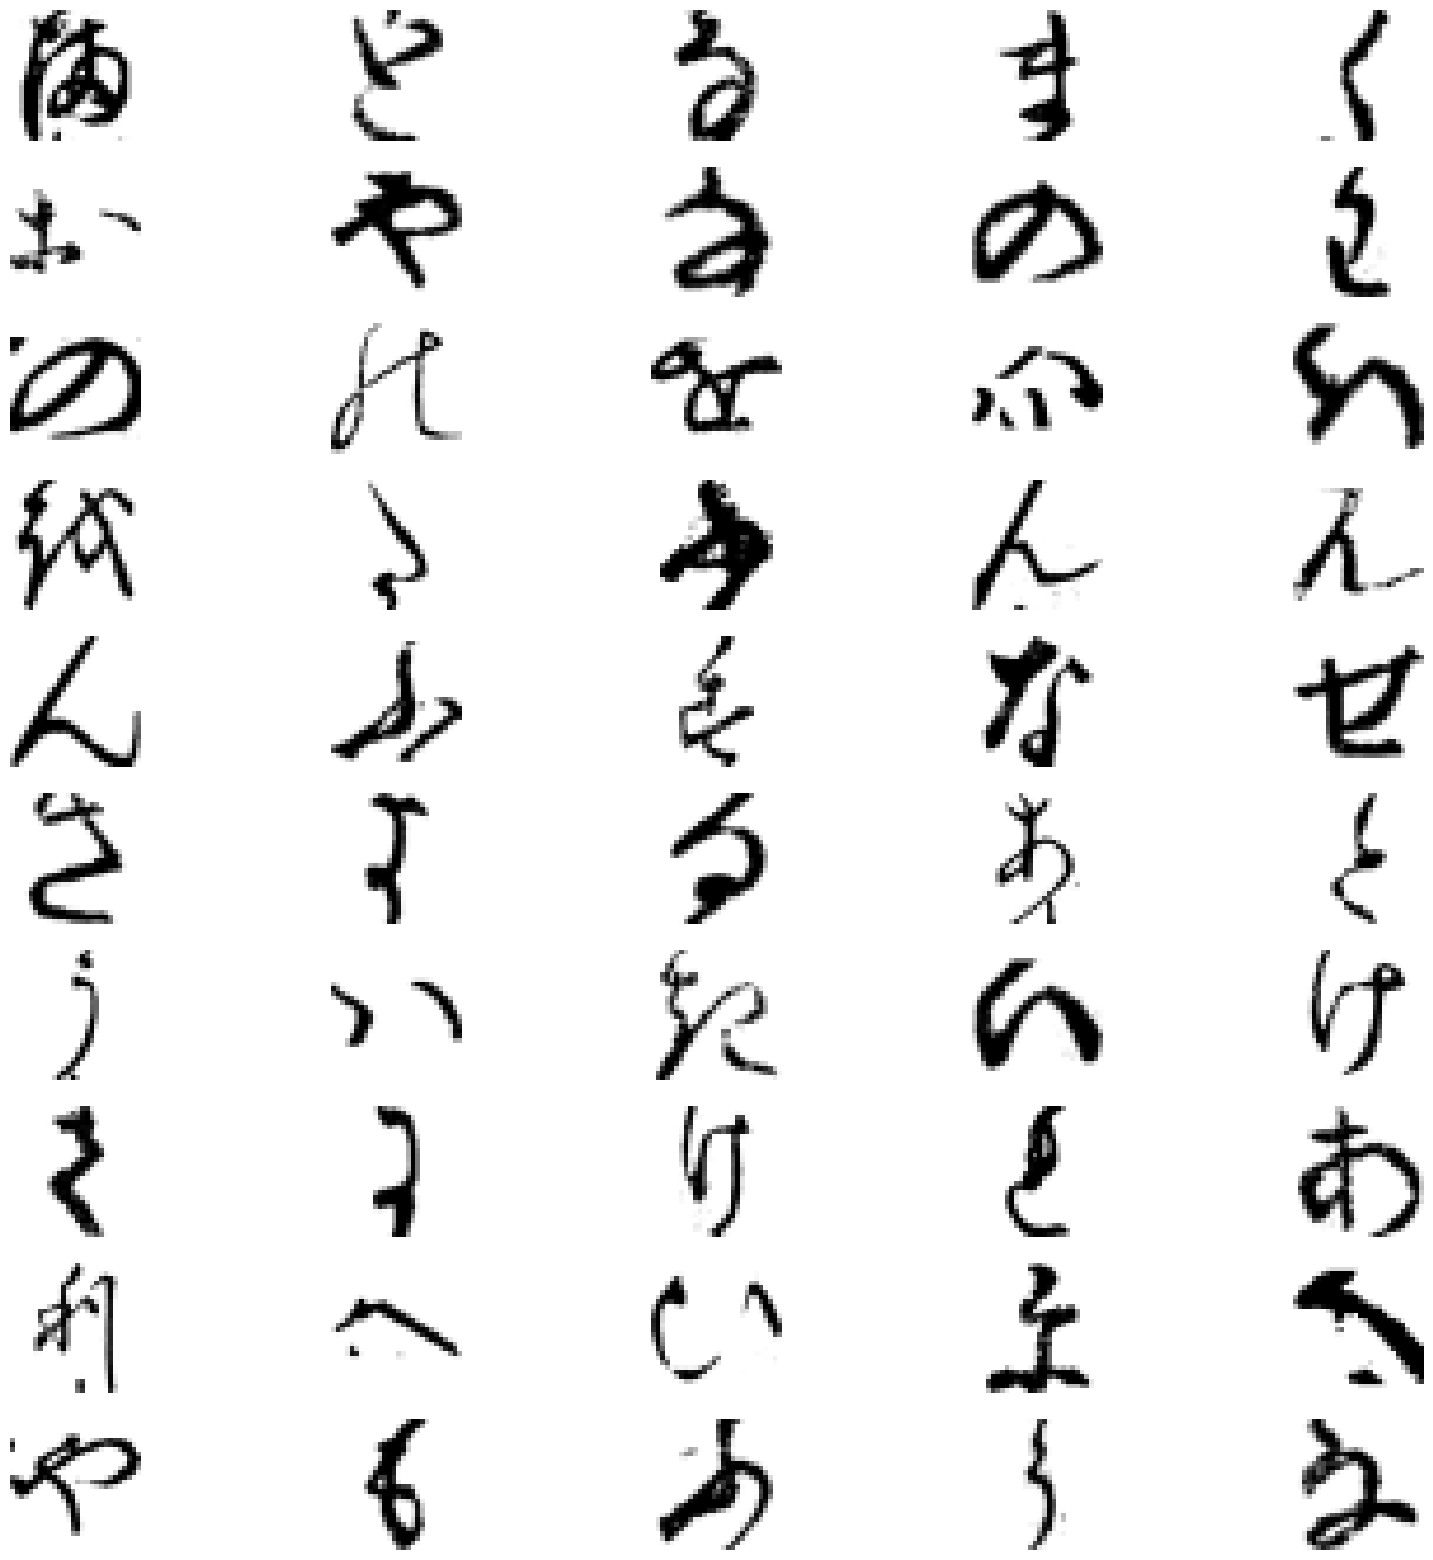

In [5]:
plt.figure(figsize=(20,20))
for i in range(0,50) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X_train[i].reshape(28,28), cmap="gray_r")

In [6]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) / 255
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) / 255

num_class = len(np.unique(Y_train))
                
Y_train = to_categorical(Y_train, num_class)
Y_test = to_categorical(Y_test, num_class)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.2, random_state = 100)

## Augmentation

Since we're woking with small (28x28x1) graysclade images containing hadwritten kanji, we can't apply horizontal or vertical flip, as well as a big rotation rotation (40+ degrees). It is because kanji are always written in the similar form and position, and definitely are not rotated or flipped any way.

That's why we decided to use horizontal/vertical shift equal to 10% of image size (~3 pixels) as well as zooming (10%). These transformations definitely will retain original kanji shape even if it is a bit shifted, zoomed in, or rotated a bit (10 degrees).

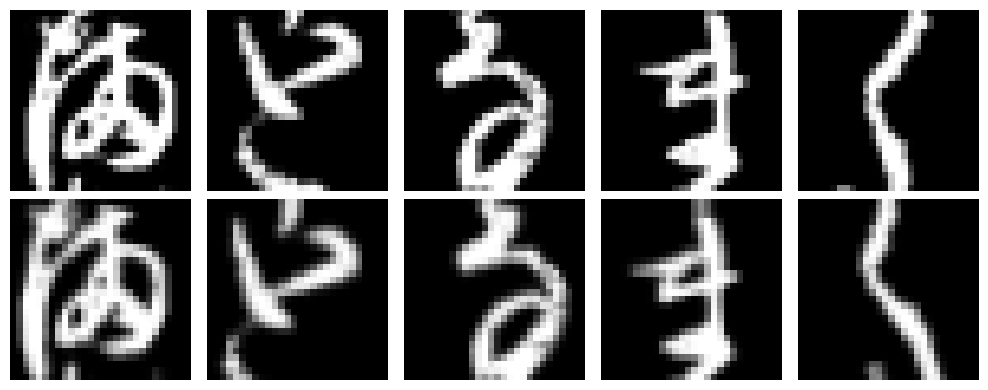

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
        width_shift_range=0.1,  # shift the image horizontally by 20% of the width
        height_shift_range=0.1,  # shift the image vertically by 20% of the height
        rotation_range=20,  # rotate the image by 20 degrees
        zoom_range=0.1,  # zoom in or out of the image by 20%
        fill_mode='nearest'  # fill any new pixels with the nearest pixel value
)

# # create a generator to generate augmented images from the in-memory images
# image_generator = datagen.flow(X_train, batch_size=1)

# plot some of the generated images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(5):
    aug_image = datagen.random_transform(
        X_train[i], seed=i
    )
    axs[i].imshow(X_train[i].squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i+5].imshow(aug_image.squeeze(), cmap='gray')
    axs[i+5].axis('off')
    
plt.tight_layout()
plt.show()

In [8]:
# add 0.1% of augmented data to the training dataset
for i in tqdm(range(int(len(X_train)/1000)), ncols=100):
    aug_image = datagen.random_transform(
        X_train[i], seed=i
    )
    # append the new image to X_train
    X_train = np.concatenate([X_train, np.expand_dims(aug_image, axis=0)])
    # append the corresponding label to Y_train
    Y_train = np.concatenate([Y_train, np.expand_dims(Y_train[i], axis=0)])

100%|█████████████████████████████████████████████████████████████| 232/232 [01:41<00:00,  2.28it/s]


In [9]:
print(f"""
Train set dimensions: {X_train.shape}, {Y_train.shape}
Test set dimensions: {X_test.shape}, {Y_test.shape}
Validation set dimensions: {X_val.shape}, {Y_val.shape}
""")


Train set dimensions: (232597, 28, 28, 1), (232597, 49)
Test set dimensions: (30837, 28, 28, 1), (30837, 49)
Validation set dimensions: (7710, 28, 28, 1), (7710, 49)



## NN definition

In [18]:
def build_model(filter_count, dropout):
    model = Sequential()
    # First convolution
    model.add(Conv2D(filter_count,(7,7),activation = 'relu', input_shape = (28,28,1), padding="same"))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    # Second convolution
    model.add(Conv2D(filter_count * 2,(5,5),activation = 'relu'))
    # Third convolution
    model.add(Conv2D(filter_count * 4,(3,3),activation = 'relu'))
    model.add(Flatten())
    # Feature extracture
    model.add(Dense(filter_count * 4,activation = 'relu'))
    model.add(Dropout(dropout))
    # Output layer
    model.add(Dense(num_class,activation = 'softmax', kernel_regularizer='l2'))

    model.summary()

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = "Adam",
                  metrics = ['accuracy'])
    return model

In [20]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
# Stop run if there is no val_loss improvement over 2 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=2)

def train():
    # default hyperparameters
    config_defaults = {
        'learning_rate': 0.01,
        'filter_count': 4,
        'batch_size':64,
        'dropout': 0.2,
    }
    wandb.init(config=config_defaults)
    
    wandb_cb = WandbCallback()

    # Configure the model
    config = wandb.config
    with strategy.scope():
        model = build_model(config.filter_count, config.dropout)
        
        # Train the model
        history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=config.batch_size,
                    verbose = 0,
                    validation_data = (X_val,Y_val),
                    callbacks=[
                        early_stop,
                        wandb_cb
                    ])
    

    # Log the results
    metrics = {
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1]
    }
    # wandb.log(metrics)
    print(config)

In [21]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'filter_count': {
            'values': [4, 8, 16]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3, 0.4]
        },
        'batch_size': {
            'values': [64, 128]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb.agent(sweep_id, function=train, count=10)

Create sweep with ID: zmk7sieu
Sweep URL: https://wandb.ai/peter-kudela/uncategorized/sweeps/zmk7sieu


wandb: Agent Starting Run: zthfuqdr with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	filter_count: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 4)         200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 4)        16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 8)         808       
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 flatten (Flatten)           (None, 1024)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_060804-zthfuqdr\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.2, 'filter_count': 4, 'learning_rate': 0.01}


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
accuracy,0.714
best_epoch,8
best_val_loss,1.08179
epoch,9
loss,1.04592
val_accuracy,0.73424


wandb: Agent Starting Run: b5c8qo85 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	filter_count: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 4)         200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 4)        16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 8)         808       
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          1168      
                                                                 
 flatten (Flatten)           (None, 1024)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061005-b5c8qo85\files\model-best)... Done. 0.0s


{'batch_size': 64, 'dropout': 0.2, 'filter_count': 4, 'learning_rate': 0.01}


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▂▁▁
accuracy,0.72942
best_epoch,8
best_val_loss,1.0542
epoch,9
loss,0.99296
val_accuracy,0.74202


wandb: Agent Starting Run: e6l7dok1 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061343-e6l7dok1\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▇▇▇████
epoch,▁▂▃▄▅▅▆▇█
loss,█▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▇▆██▇
val_loss,█▃▃▂▂▂▁▁▂
accuracy,0.96825
best_epoch,6
best_val_loss,0.31813
epoch,8
loss,0.12993
val_accuracy,0.92996


wandb: Agent Starting Run: iupxxl7s with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_061835-iupxxl7s\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▇▇███
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇█
val_loss,█▃▂▂▁▁▁
accuracy,0.9635
best_epoch,4
best_val_loss,0.33319
epoch,6
loss,0.14767
val_accuracy,0.92879


wandb: Agent Starting Run: 8z5x3p0c with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062040-8z5x3p0c\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇▇█▇
val_loss,█▄▃▂▂▁▁▁▁▂
accuracy,0.96916
best_epoch,8
best_val_loss,0.32669
epoch,9
loss,0.12531
val_accuracy,0.9227


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ttwxx8wr with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062255-ttwxx8wr\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▅▅▆▇▇██▇
val_loss,█▄▃▃▂▂▂▁▁▂
accuracy,0.96691
best_epoch,8
best_val_loss,0.32195
epoch,9
loss,0.13369
val_accuracy,0.92633


wandb: Agent Starting Run: kvixbisr with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062522-kvixbisr\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▇▇██
epoch,▁▂▄▅▇█
loss,█▃▂▂▁▁
val_accuracy,▁▃▆█▇█
val_loss,█▅▃▁▂▂
accuracy,0.96122
best_epoch,3
best_val_loss,0.3227
epoch,5
loss,0.15914
val_accuracy,0.92529


wandb: Agent Starting Run: 4xwkt5ya with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062656-4xwkt5ya\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▇▇▇███
epoch,▁▂▃▄▅▆▇█
loss,█▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇███
val_loss,█▄▃▂▂▁▁▂
accuracy,0.96254
best_epoch,5
best_val_loss,0.33139
epoch,7
loss,0.14989
val_accuracy,0.92464


wandb: Agent Starting Run: nsj1he9c with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_062850-nsj1he9c\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▇▇█▇███
val_loss,█▄▄▁▁▁▂▁▁▂
accuracy,0.96745
best_epoch,7
best_val_loss,0.32849
epoch,9
loss,0.1305
val_accuracy,0.92503


wandb: Agent Starting Run: 3dglzpyq with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	filter_count: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\peter\Desktop\Repositories\NN2023_MLP_abalone_age_prediction\wandb\run-20230410_063100-3dglzpyq\files\model-best)... Done. 0.0s


{'batch_size': 128, 'dropout': 0.1, 'filter_count': 16, 'learning_rate': 0.01}


accuracy,▁▆▆▇▇▇███
epoch,▁▂▃▄▅▅▆▇█
loss,█▃▂▂▂▁▁▁▁
val_accuracy,▁▅▂▅█▇██▇
val_loss,█▄▆▃▂▁▁▂▂
accuracy,0.96886
best_epoch,6
best_val_loss,0.31634
epoch,8
loss,0.12803
val_accuracy,0.92581


In [13]:
sweep_obj = wandb.Api().sweep('peter-kudela/uncategorized/sweeps/' + sweep_id)
best_config = sweep_obj.best_run().config

print("Best run config:")
print(best_config)

wandb: Sorting runs by -summary_metrics.val_accuracy


Best run config:
{'dropout': 0.4, 'batch_size': 64, 'filter_count': 8, 'learning_rate': 0.09308570364549516}


In [14]:
model = build_model(best_config['filter_count'], best_config['dropout'], best_config['learning_rate'])
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=128,
                    verbose = 1,
                    validation_data = (X_val,Y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         400       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 2048)              0

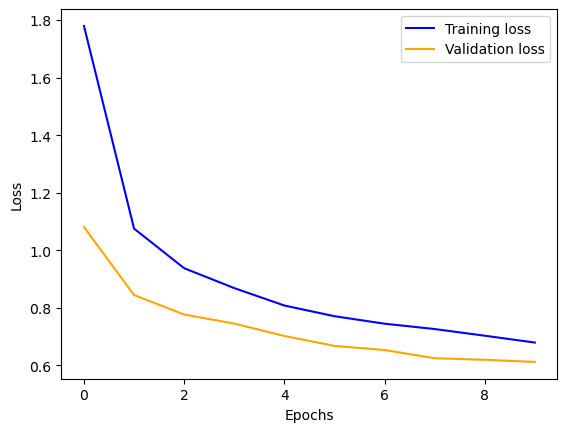

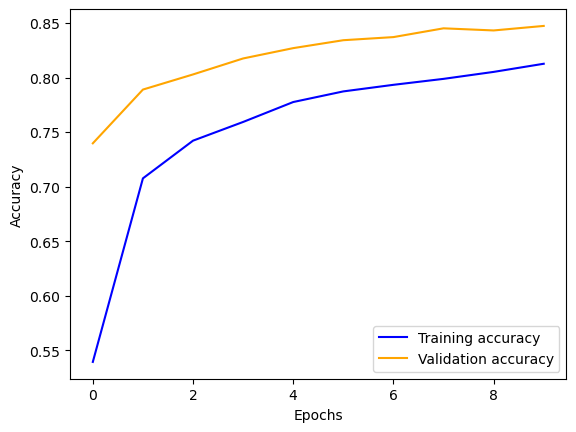

In [15]:
plt.plot(history.history['loss'], label = 'Training loss', color = 'blue')
plt.plot(history.history['val_loss'], label = 'Validation loss', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'], label = 'Training accuracy', color = 'blue')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Prediction

In [16]:
def get_kanji_by_idx(idx):
    return label_map[label_map['index'] == idx]['char'].values[0]

In [17]:
import random
history.history

print("Evaluate model on test data")
results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:

idxs = []

for i in range(100):
    idxs.append(random.randint(1, len(X_test)))
    
prediction = model.predict(X_test[idxs])
print("prediction shape:", prediction.shape)

for i in range(len(prediction)):
    pred_idx = np.argmax(prediction[i])
    true_idx = np.argmax(Y_test[idxs[i]])
    if pred_idx != true_idx:
        print(f"{i}: Predicted {get_kanji_by_idx(pred_idx)} / Original {get_kanji_by_idx(true_idx)}")

Evaluate model on test data
241/241 [==============================] - 1s 5ms/step - loss: 0.6318 - accuracy: 0.8418
test loss, test acc: [0.6318284869194031, 0.8418133854866028]
4/4 [==============================] - 0s 26ms/step
prediction shape: (100, 49)
4: Predicted ぬ / Original ひ
8: Predicted つ / Original あ
13: Predicted こ / Original し
20: Predicted あ / Original な
23: Predicted き / Original る
25: Predicted ね / Original な
28: Predicted え / Original の
30: Predicted み / Original と
38: Predicted き / Original も
40: Predicted な / Original ね
45: Predicted の / Original ま
53: Predicted な / Original や
54: Predicted な / Original ひ
58: Predicted め / Original ゐ
62: Predicted ゝ / Original ら
70: Predicted も / Original ひ
81: Predicted ゆ / Original し
89: Predicted や / Original り
99: Predicted ま / Original こ
